# Evaluation

In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib
import pandas as pd
import pickle
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
from src import utils
import os
import random

utils.plot_style()
torch.manual_seed(1234)
random.seed(1234)
np.random.seed(1234)
os.makedirs('plots/', exist_ok=True)

In [2]:
intensity_scales = [50, 100, 200, 300, 400]
n_runs = 10

In [3]:
df_data = []

z_inferred_dict = {}
w_inferred_dict = {}

avg_n_molecules = []

for intensity_scale in intensity_scales:
    z_inferred_dict[intensity_scale] = {}
    w_inferred_dict[intensity_scale] = {}
    data = torch.load('../../data/simulated/data/shared/0_{}.pt'.format(intensity_scale))
    avg_n_molecules.append(round(data['coordinates'].shape[0] / (data['n_genes'] * data['n_cells'])))
    for run in range(n_runs):
        results = pickle.load(open('results/{}_{}/final/latents.pkl'.format(intensity_scale, run), 'rb'))

        z_inferred = results['z']
        n_cells = z_inferred.shape[0]
        n_factors = z_inferred.shape[1]
        z_inferred = torch.nan_to_num(z_inferred, 0)
        z_inferred /= z_inferred.flatten(start_dim=2).max(dim=-1)[0].view(n_cells, n_factors, 1, 1)
        z_data = data['z'][:n_cells]

        w_inferred = results['w']
        w_inferred /= w_inferred.max(dim=0)[0].view(1, n_factors)
        w_data = data['w']

        inds, _ = utils.optimal_assignment(z_data, z_inferred, 1)

        z_inferred = z_inferred[:, inds]
        w_inferred = w_inferred[:, inds]

        w_corr = pearsonr(w_data.flatten(), w_inferred.flatten())[0]
        z_corr = pearsonr(z_data.flatten(), z_inferred.flatten())[0]

        z_inferred_dict[intensity_scale][run] = z_inferred
        w_inferred_dict[intensity_scale][run] = w_inferred

        df_data.append(pd.DataFrame({
            'intensity_scale' : intensity_scale,
            'run' : run,
            'w_corr' : w_corr,
            'z_corr' : z_corr,
        }, index=[0]))

df_data = pd.concat(df_data).reset_index(drop=True)

In [4]:
w_corr_matrix_dict = {}
z_corr_matrix_dict = {}

for intensity_scale in intensity_scales:
    z_corr_matrix = np.zeros([n_runs, n_runs])
    w_corr_matrix = np.zeros([n_runs, n_runs])

    for i in range(n_runs):
        for j in range(n_runs):
            if i > j:
                w_corr_matrix[i, j] = np.nan
                z_corr_matrix[i, j] = np.nan
                continue

            w_corr_matrix[i, j] = pearsonr(w_inferred_dict[intensity_scale][i].flatten(), w_inferred_dict[intensity_scale][j].flatten())[0]
            z_corr_matrix[i, j] = pearsonr(z_inferred_dict[intensity_scale][i].flatten(), z_inferred_dict[intensity_scale][j].flatten())[0]

    w_corr_matrix_dict[intensity_scale] = w_corr_matrix
    z_corr_matrix_dict[intensity_scale] = z_corr_matrix

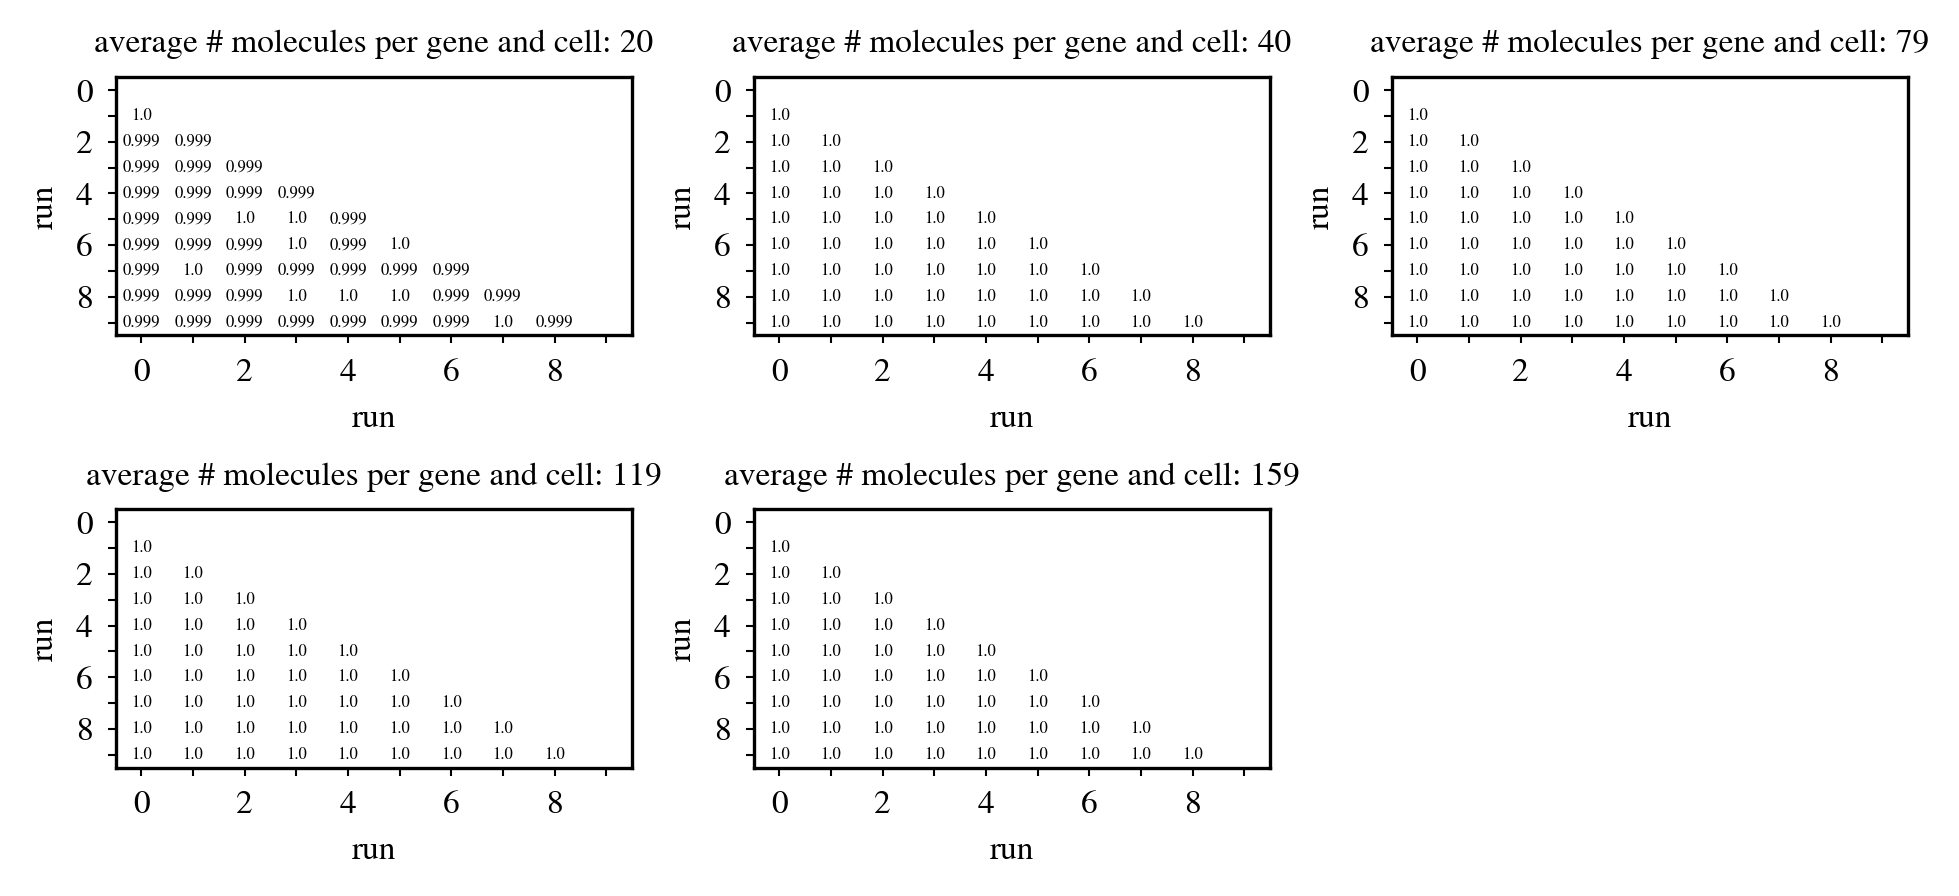

In [5]:
ticklabels = [0, '', 2, '', 4, '', 6, '', 8, '']

fig, axs = plt.subplots(2, 3, figsize=(6.5, 3), dpi=300)
for i, intensity_scale in enumerate(intensity_scales):
    ax = axs.flatten()[i]
    ax.matshow(w_corr_matrix_dict[intensity_scale].T, aspect=0.5, vmin=0.95, vmax=1., alpha=0.)
    ax.set_xticks(np.arange(10))
    ax.set_xticklabels(ticklabels)
    ax.set_yticks(np.arange(10))
    ax.set_yticklabels(ticklabels)
    ax.set_title('average # molecules per gene and cell: {}'.format(avg_n_molecules[i]))
    ax.set_xlabel('run')
    ax.set_ylabel('run')
    ax.xaxis.set_ticks_position('bottom')
    for i in range(10):
        for j in range(10):
            if i < j:
                text = ax.text(i, j, round(w_corr_matrix_dict[intensity_scale][i, j], 3), ha="center", va="center", color="black", size=4)

axs[1, 2].axis('off')

plt.tight_layout()
plt.savefig('plots/weights_correlation.svg')

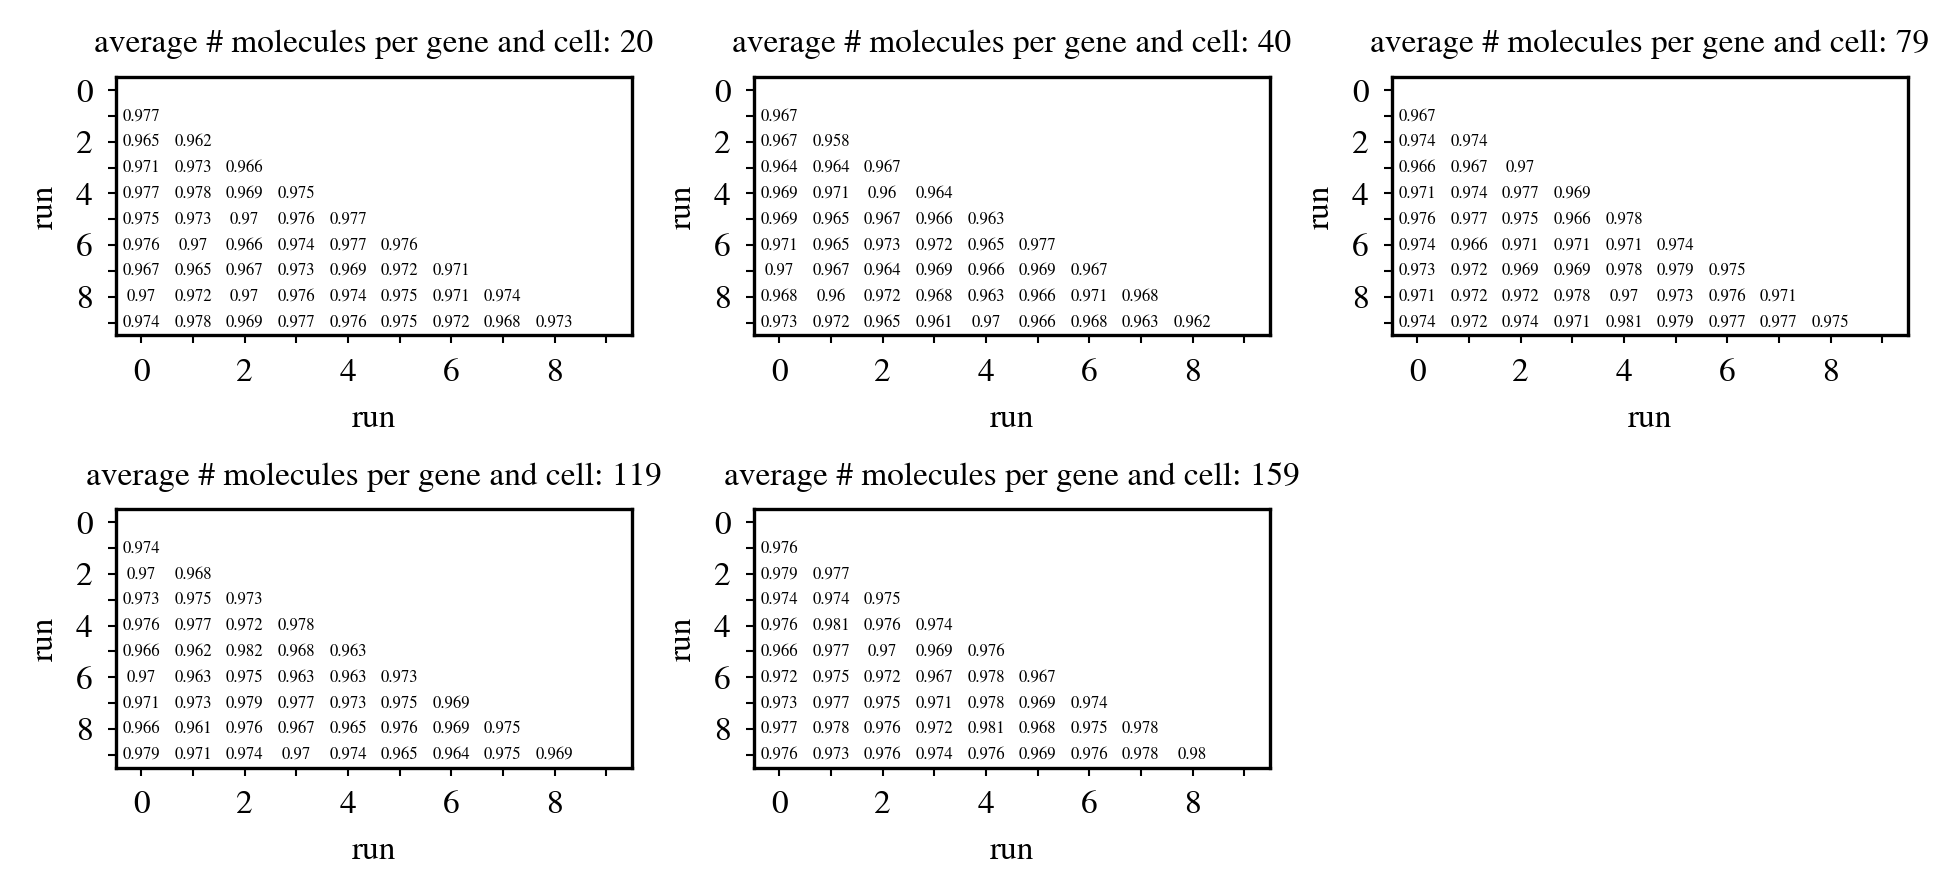

In [6]:
ticklabels = [0, '', 2, '', 4, '', 6, '', 8, '']

fig, axs = plt.subplots(2, 3, figsize=(6.5, 3), dpi=300)
for i, intensity_scale in enumerate(intensity_scales):
    ax = axs.flatten()[i]
    ax.matshow(z_corr_matrix_dict[intensity_scale].T, aspect=0.5, vmin=0.95, vmax=1., alpha=0.)
    ax.set_xticks(np.arange(10))
    ax.set_xticklabels(ticklabels)
    ax.set_yticks(np.arange(10))
    ax.set_yticklabels(ticklabels)
    ax.set_title('average # molecules per gene and cell: {}'.format(avg_n_molecules[i]))
    ax.set_xlabel('run')
    ax.set_ylabel('run')
    ax.xaxis.set_ticks_position('bottom')
    for i in range(10):
        for j in range(10):
            if i < j:
                text = ax.text(i, j, round(z_corr_matrix_dict[intensity_scale][i, j], 3), ha="center", va="center", color="black", size=4)

axs[1, 2].axis('off')

plt.tight_layout()
plt.savefig('plots/factors_correlation.svg')

In [16]:
min_corr = []
mean_corr = []

for intensity_scale in w_corr_matrix_dict.keys():
    min_corr.append(np.nanmin(w_corr_matrix_dict[intensity_scale]))
    mean_corr.append(np.nanmean(w_corr_matrix_dict[intensity_scale]))
    
print(min(min_corr), sum(mean_corr) / len(mean_corr))

0.9991786656699473 0.999785915558264


In [17]:
min_corr = []
mean_corr = []

for intensity_scale in z_corr_matrix_dict.keys():
    min_corr.append(np.nanmin(z_corr_matrix_dict[intensity_scale]))
    mean_corr.append(np.nanmean(z_corr_matrix_dict[intensity_scale]))
    
print(min(min_corr), sum(mean_corr) / len(mean_corr))

0.9583137048622997 0.9767142986234791
